In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.utils import shuffle
from math import log

## Data cleaning

In [27]:
train = pd.read_csv('./exp1_14drivers_14cars_dailyRoutes.csv')
train = train.dropna(how='all')

# test = pd.read_csv('./exp2_19drivers_1car_1route.csv')
# test = test.dropna(how='all')

c:\Users\night\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (1,2,4,5,6,9,10,14,15,16,20,21,22,23,24,25,26,27) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [28]:
# utility function
def get_sec(time_str):
    h, m, s = time_str.split(':')
    return float(h) * 3600 + float(m) * 60 + float(s)

In [29]:
# train set wrangling 
train_imputed = train.loc[train['SPEED'] != 0]
train_imputed = train_imputed.dropna(subset=['SPEED', 'MAF'])
train_imputed['MAF'] = train_imputed['MAF'].apply(lambda x : float(x.replace(',', '.')))
train_imputed['ENGINE_POWER'] = train_imputed['ENGINE_POWER'].apply(lambda x : float(x.replace(',', '.')))
train_imputed['FUEL_LEVEL'] = train_imputed['FUEL_LEVEL'].fillna('0,0%')
train_imputed['FUEL_LEVEL'] = train_imputed['FUEL_LEVEL'].apply(lambda x : float(x.replace('%', '').replace(',', '.')))
train_imputed['ENGINE_LOAD'] = train_imputed['ENGINE_LOAD'].apply(lambda x : float(x.replace('%', '').replace(',', '.')))
train_imputed['SHORT TERM FUEL TRIM BANK 1'] = train_imputed['SHORT TERM FUEL TRIM BANK 1'].fillna('0%')
train_imputed['SHORT TERM FUEL TRIM BANK 1'] = train_imputed['SHORT TERM FUEL TRIM BANK 1'].apply(lambda x : float(x.replace('%', '')))
train_imputed['THROTTLE_POS'] = train_imputed['THROTTLE_POS'].fillna('0,0%')
train_imputed['THROTTLE_POS'] = train_imputed['THROTTLE_POS'].apply(lambda x : float(x.replace('%', '').replace(',', '.')))
train_imputed['TIMING_ADVANCE'] = train_imputed['TIMING_ADVANCE'].fillna('0,0%')
train_imputed['TIMING_ADVANCE'] = train_imputed['TIMING_ADVANCE'].apply(lambda x : float(x.replace('%', '').replace(',', '.')))
train_imputed['EQUIV_RATIO'] = train_imputed['EQUIV_RATIO'].fillna('0,0%')
train_imputed['EQUIV_RATIO'] = train_imputed['EQUIV_RATIO'].apply(lambda x : float(x.replace('%', '').replace(',', '.')))
train_imputed['ENGINE_RUNTIME'] = train_imputed['ENGINE_RUNTIME'].fillna('0:0:0')
train_imputed['ENGINE_RUNTIME'] = train_imputed['ENGINE_RUNTIME'].apply(lambda x: get_sec(x))

In [30]:
# 14 features train set
train_imputed = train_imputed.drop(columns=['FUEL_PRESSURE', 'LONG TERM FUEL TRIM BANK 2', 'SHORT TERM FUEL TRIM BANK 2', 'TROUBLE_CODES', 'FUEL_TYPE', 'DTC_NUMBER',
                                    'YEAR', 'MONTHS', 'DAYS_OF_WEEK', 'HOURS', 'MIN', 'MARK',  'MODEL','AUTOMATIC', 'TIMESTAMP', 'BAROMETRIC_PRESSURE(KPA)',
                                    'CAR_YEAR', 'ENGINE_POWER', 'ENGINE_COOLANT_TEMP', 'AMBIENT_AIR_TEMP', 'INTAKE_MANIFOLD_PRESSURE', 
                                    'AIR_INTAKE_TEMP', 'TIMING_ADVANCE', 'EQUIV_RATIO'] )
train_imputed = train_imputed.interpolate()
train_imputed = train_imputed.loc[train_imputed['ENGINE_RUNTIME'] != 0]
train_imputed = train_imputed.dropna()
train_imputed = train_imputed.reset_index(drop = True)

In [31]:
'''calculate fuel rate using the formula: 
fuel rate [L/H] = (MAF * 3600) / AFR / FD
where AFR = air-to-fuel ratio and FD = fuel density
both AFR and FD are constants 

calculate fuel consumption using the formula: 
fuel consumption [L/100KM] = fuel rate / speed * 100 '''

train_imputed['FUEL_RATE'] = (train_imputed['MAF'] * 3600) / 14.7 / 820

train_imputed['FUEL_CONSUMPTION'] = (train_imputed['FUEL_RATE'] / train_imputed['SPEED']) * 100

In [32]:
train_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10348 entries, 0 to 10347
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   VEHICLE_ID                   10348 non-null  object 
 1   FUEL_LEVEL                   10348 non-null  float64
 2   ENGINE_LOAD                  10348 non-null  float64
 3   ENGINE_RPM                   10348 non-null  float64
 4   MAF                          10348 non-null  float64
 5   SPEED                        10348 non-null  float64
 6   SHORT TERM FUEL TRIM BANK 1  10348 non-null  float64
 7   ENGINE_RUNTIME               10348 non-null  float64
 8   THROTTLE_POS                 10348 non-null  float64
 9   FUEL_RATE                    10348 non-null  float64
 10  FUEL_CONSUMPTION             10348 non-null  float64
dtypes: float64(10), object(1)
memory usage: 889.4+ KB


## Pseudo-inverse polynomial fuel estimation

In [33]:
rpm = train_imputed['ENGINE_RPM']
load = train_imputed['ENGINE_LOAD']
y = train_imputed['MAF'] / 14.7 / 1000 # mass fuel flow rate [kg/s]

rpm2 = rpm.apply(lambda x: np.power(x, 2))
rpm3 = rpm.apply(lambda x: np.power(x, 3))
load2 = load.apply(lambda x: np.power(x, 2))
rpm_load = rpm * load
rpm2_load = rpm2 * load
rpm_load2 = rpm * load2
rpm3_load = rpm3 * load
rpm2_load2 = rpm2 * load2

In [34]:
L2 = np.concatenate((np.matrix(rpm).T, np.matrix(rpm_load).T, np.matrix(rpm2_load).T, np.matrix(rpm3_load).T, np.matrix(rpm_load2).T, np.matrix(rpm2_load2).T), axis=1) #L2
L2 = np.dot(np.linalg.pinv(L2), y)

In [35]:
# predict ideal fuel consumptions
optimal_L2 = []


for i in range(0, len(train_imputed)):
   mfr_L2 = (L2[0, 0] * rpm[i] + L2 [0, 1] * rpm_load[i] + L2 [0, 2]  * rpm2_load[i] - 
         L2[0, 3]* rpm3_load[i] + L2[0, 4] * rpm_load2[i] - L2[0, 5] * rpm2_load2[i]) 
         
   optimal_L2.append(mfr_L2)

ideal_fuel_rate_L2 = pd.Series(map(lambda x: x * (3600 / 820) * 1000, optimal_L2)) # fuel flow rate [l/h]
ideal_fuel_consumption_L2 = (ideal_fuel_rate_L2 / train_imputed['SPEED']) * 100 # fuel consumption [l/km]
train_imputed['IDEAL_FUEL_CONSUMPTION_L2'] = ideal_fuel_consumption_L2
train_imputed['IDEAL_SPEED'] = train_imputed['FUEL_RATE'] / (train_imputed['IDEAL_FUEL_CONSUMPTION_L2'] / 100) 

In [36]:
SPEED_CHANGE = []

for i in range(1, len(train_imputed)):
    change_rate = (train_imputed['SPEED'].values[i] - train_imputed['SPEED'].values[i - 1]) / (
        train_imputed['ENGINE_RUNTIME'].values[i] - train_imputed['ENGINE_RUNTIME'].values[i - 1])
    if change_rate < 1:
        change_rate = 1
    SPEED_CHANGE.append(change_rate)

SPEED_CHANGE.insert(0, train_imputed['SPEED'].values[0])
train_imputed['SPEED_CHANGE_RATE'] = [abs(x) for x in SPEED_CHANGE]
train_imputed['MODIFIED_SPEED'] = [(x / 220) for x in train_imputed['SPEED']]

In [37]:
RPM_CHANGE = []

for i in range(1, len(train_imputed)):
    change_rate = (train_imputed['ENGINE_RPM'].values[i] - train_imputed['ENGINE_RPM'].values[i - 1]) / (
        train_imputed['ENGINE_RUNTIME'].values[i] - train_imputed['ENGINE_RUNTIME'].values[i - 1])
    if change_rate < 1:
        change_rate = 1
    RPM_CHANGE.append(change_rate)

RPM_CHANGE.insert(0, train_imputed['ENGINE_RPM'].values[0])
train_imputed['RPM_CHANGE_RATE'] = [abs(x) for x in RPM_CHANGE]
train_imputed['MODIFIED_RPM'] = [(x / 8000) for x in train_imputed['ENGINE_RPM']]
train_imputed['SPEED_RPM_RATIO'] = train_imputed['MODIFIED_SPEED'] / train_imputed['MODIFIED_RPM']

In [38]:
THROTTLE_CHANGE = []

for i in range(1, len(train_imputed)):
    change_rate = (train_imputed['THROTTLE_POS'].values[i] - train_imputed['THROTTLE_POS'].values[i - 1]) / (
        train_imputed['ENGINE_RUNTIME'].values[i] - train_imputed['ENGINE_RUNTIME'].values[i - 1])

    THROTTLE_CHANGE.append(change_rate)

THROTTLE_CHANGE.insert(0, train_imputed['THROTTLE_POS'].values[0])
train_imputed['THROTTLE_CHANGE_RATE'] = [abs(x) for x in THROTTLE_CHANGE]

In [39]:
print(max(train_imputed['THROTTLE_CHANGE_RATE']))
print(max(train_imputed['RPM_CHANGE_RATE']))

27.0
1004.0


In [40]:
train_imputed['MODIFIED_THROTTLE_RATE'] = [(x / 8.5) for x in train_imputed['THROTTLE_CHANGE_RATE']]
train_imputed['MODIFIED_RPM_RATE'] = [(x / 324) for x in train_imputed['RPM_CHANGE_RATE']]
train_imputed['THROTTLE_RPM_RATIO'] = train_imputed['MODIFIED_THROTTLE_RATE'] / train_imputed['MODIFIED_RPM_RATE']


In [41]:
car1 = train_imputed.loc[train_imputed['VEHICLE_ID'] == 'car1']
car2 = train_imputed.loc[train_imputed['VEHICLE_ID'] == 'car11']
car3 = train_imputed.loc[train_imputed['VEHICLE_ID'] == 'car12']

In [42]:
cut_point = []
for i in range(1, len(car2)):
    if car2['ENGINE_RUNTIME'].values[i] < car2['ENGINE_RUNTIME'].values[i - 1]:
        cut_point.append(i) 

print(cut_point)

[124, 235, 237, 658, 755, 804, 1431, 1822, 2313, 2350, 2609, 2775, 2806, 3203, 3348, 3806, 3821, 3896, 4057, 4616, 4634, 4698, 4721, 5317, 5453, 5482, 5547, 5657, 6322, 6459, 6697]


Text(0, 0.5, 'Fuel Consumption / L')

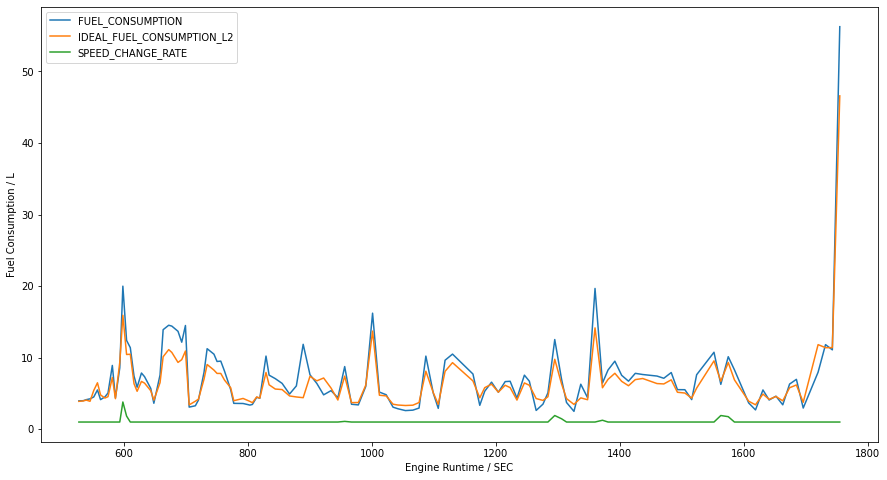

In [43]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(15)

car2[:cut_point[0]].plot('ENGINE_RUNTIME', 'FUEL_CONSUMPTION', ax = ax)
car2[:cut_point[0]].plot('ENGINE_RUNTIME', 'IDEAL_FUEL_CONSUMPTION_L2', ax = ax)
car2[:cut_point[0]].plot('ENGINE_RUNTIME', 'SPEED_CHANGE_RATE', ax = ax)

plt.legend(["FUEL_CONSUMPTION", "IDEAL_FUEL_CONSUMPTION_L2", "SPEED_CHANGE_RATE"])
plt.xlabel('Engine Runtime / SEC')
plt.ylabel('Fuel Consumption / L')

Text(0, 0.5, 'Speed Change Rate / KM/H')

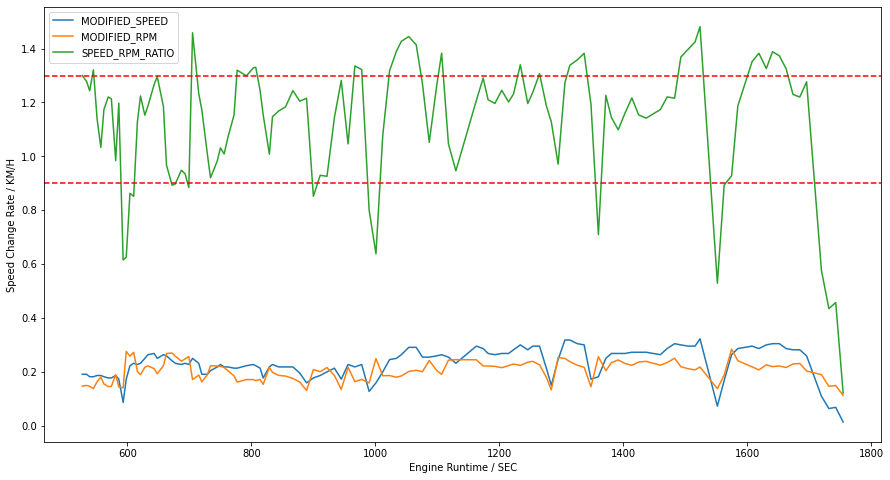

In [44]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(15)


car2[:cut_point[0]].plot('ENGINE_RUNTIME', 'MODIFIED_SPEED', ax = ax)
car2[:cut_point[0]].plot('ENGINE_RUNTIME', 'MODIFIED_RPM', ax = ax)
car2[:cut_point[0]].plot('ENGINE_RUNTIME', 'SPEED_RPM_RATIO', ax = ax)
ax.axhline(y = 1.3, color='r', linestyle='--')
ax.axhline(y = 0.9, color='r', linestyle='--')

plt.legend(['MODIFIED_SPEED', 'MODIFIED_RPM', "SPEED_RPM_RATIO"])
plt.xlabel('Engine Runtime / SEC')
plt.ylabel('Speed Change Rate / KM/H')

c:\Users\night\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Text(0, 0.5, 'Speed Change Rate / KM/H')

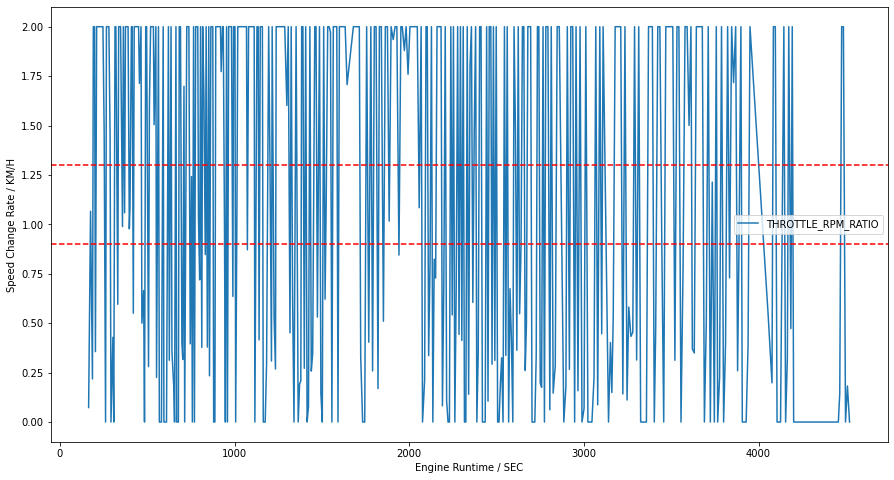

In [45]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(15)

car2['THROTTLE_RPM_RATIO'].loc[train_imputed['THROTTLE_RPM_RATIO'] > 2] = 2

car2[3348:3806].plot('ENGINE_RUNTIME', 'THROTTLE_RPM_RATIO', ax = ax)
ax.axhline(y = 1.3, color='r', linestyle='--')
ax.axhline(y = 0.9, color='r', linestyle='--')

plt.xlabel('Engine Runtime / SEC')
plt.ylabel('Speed Change Rate / KM/H')

In [46]:
# car2['IDEAL_FUEL_CONSUMPTION_L2'].mean()
# car2['FUEL_CONSUMPTION'].mean()

<AxesSubplot:>

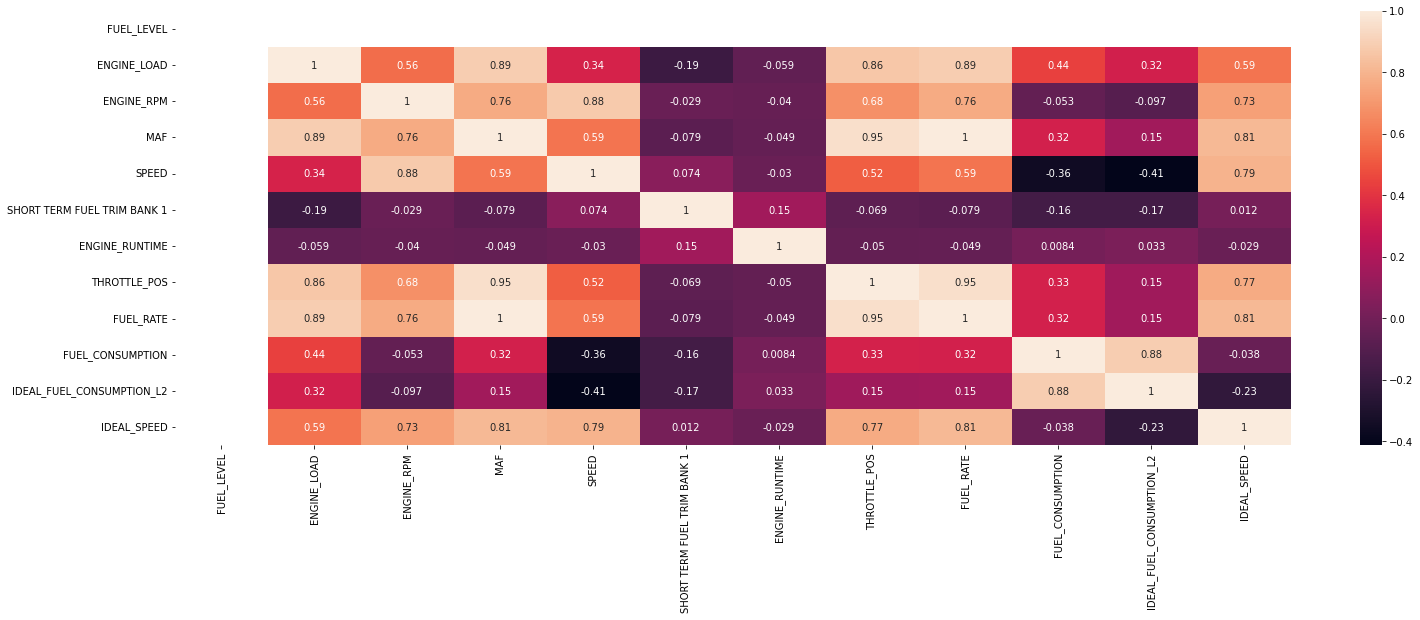

In [50]:
plt.figure(figsize = (25,8))
sns.heatmap(car2.iloc[:,:13].corr(),annot=True)